In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library.standard_gates import CRYGate

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    '''
    Returns a random number between low_in and high_in, including both end points.
    '''
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

In [4]:
'''
Define variables for the number of layers and qubits of the prover. Define global variables used in the optimization.
'''
numLayer = 3
numQubit = 4
global iterations
global noisy

In [5]:
def createProver(numQubit, numLayer):
    '''
    Creates a parameterized unitary on numQubit qubits. Applies numLayer layers of the HEA with 2 Qiskit.parameters 
    per qubit per layer, specifying rotations about the x- and y-axes. After each layer, applies a neighbouring qubit
    CNOT layer. Returns a QuantumCircuit object containing the parameterized prover. 
    '''
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

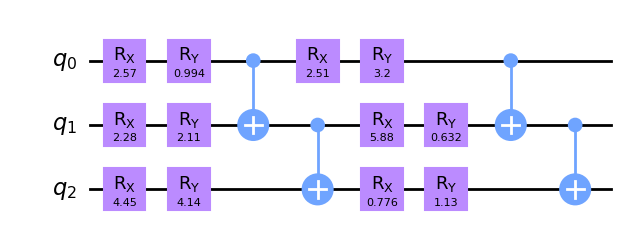

In [6]:
'''
Defines parameters that specify the purification of state to be tested. Create a QuantumCircuit object that
creates the purification on (size) number of qubits.
'''
unitary_param_1 = np.array([])
size = 3
layers = 2
for i in range(0, 2*size*layers):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [7]:
def createEqSuperpos2E():
    '''
    Defines a quantum circuit to create the uniform superposition of basis elements required.
    '''
    temp = QuantumCircuit(1)
    temp.h(0)
    return temp

In [8]:
def createWernerState(F):
    '''
    Defines a quantum circuit to create a purification of the Werner state with parameter F. Tracing out the first two
    qubits gives the Werner state.
    '''
    theta1 = 2*np.arccos(np.sqrt(0.667*(1-F)))
    theta2 = 2*np.arctan(np.sqrt(3*F/(1-F)))
    
    state = QuantumCircuit(4)
    state.ry(theta1, 2)
    state.append(CRYGate(theta2), [2, 3])
    state.x(2)
    state.ch(2, 3)
    state.x(2)
    
    state.h(0)
    state.cx(0, 1)
    
    state.cz(0, 3)
    state.cx(2, 0)
    
    return state

In [10]:
F=0.5
theta1 = 2*np.arccos(np.sqrt(0.667*(1-F)))
theta2 = 2*np.arctan(np.sqrt(3*F/(1-F)))

state = QuantumCircuit(3)
state.ry(theta1, 0)
state.append(CRYGate(theta2), [0, 1])
state.x(0)
state.ch(0, 1)
state.x(0)

In [11]:
def createQuantumCircuit(state, numQubit, numLayer):
    '''
    Creates quantum circuit for the problem. 
    Refer to Section 6.D from https://arxiv.org/pdf/2105.12758
    The ciruit contains 7 qubits each labelled as (C, A, B1, B2, \hat{A}, \hat{B1}, \hat{B2})
    '''
    circ = QuantumCircuit(7)
    
    superPosCircuit = createEqSuperpos2E()
    circ.append(superPosCircuit, [0])

    circ.append(state, [1, 2, 3])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [3, 4, 5, 6])
    
    circ.cswap(0, 2, 3)
    circ.cswap(0, 5, 6)
    
    circ.append(superPosCircuit.inverse(), [0])
    
    return circ

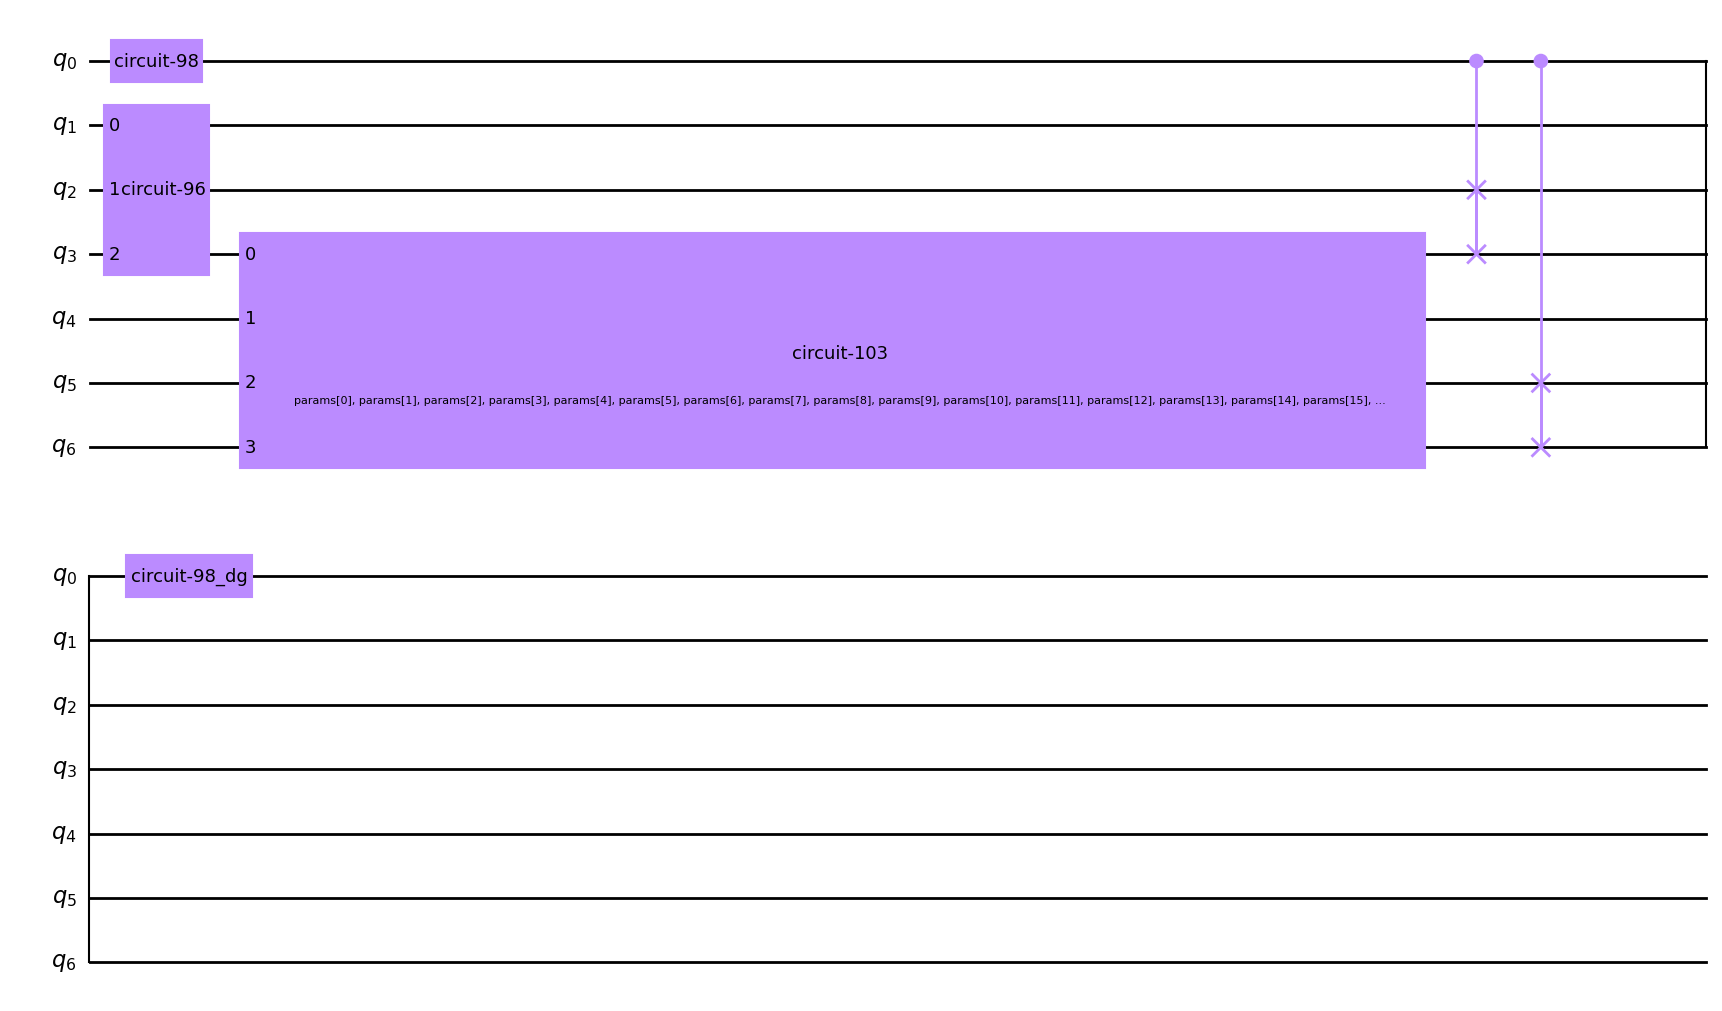

In [12]:
'''
Creates the quantum circuit
'''
qCirc = createQuantumCircuit(state, numQubit, numLayer)
qCirc.draw('mpl')

In [13]:
'''
List of parameters of the quantum circuit.
'''
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7]), ParameterVectorElement(params[8]), ParameterVectorElement(params[9]), ParameterVectorElement(params[10]), ParameterVectorElement(params[11]), ParameterVectorElement(params[12]), ParameterVectorElement(params[13]), ParameterVectorElement(params[14]), ParameterVectorElement(params[15]), ParameterVectorElement(params[16]), ParameterVectorElement(params[17]), ParameterVectorElement(params[18]), ParameterVectorElement(params[19]), ParameterVectorElement(params[20]), ParameterVectorElement(params[21]), ParameterVectorElement(params[22]), ParameterVectorElement(params[23])])


In [14]:
'''
Pick a backend to use. We use the statevector_simulator for noiseless simulation.
'''
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [15]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation.
'''
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibm_lagos")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

<ipython-input-15-634570ecb369>:8: DeprecationWarning: Passing BackendProperties instead of a "backend" object has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date. Duration dependent delay relaxation noise requires a backend object.
  noise_model = NoiseModel.from_backend(device.properties())
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (150081.2267640262 > 2 * 64056.33426064539). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (150081.2267640262 > 2 * 64056.33426064539). Truncating to maximum value.
 

In [16]:
def costf(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the expectation value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [17]:
def gradient(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the gradient value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [18]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    '''
    Callback function called automatically during optimization. Appends loss value, current iteration and 
    prints every iteration with a completion percentage.
    '''
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [19]:
'''
Average value of this hamiltonian is the probability of measuring 0 on the 1st qubit.
MatrixOp(np.array([[1, 0], [0, 0])) is the projector on the 0 subspace. Qiskit orders qubits in reverse.
'''
hamiltonian = I^I^I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))

In [20]:
'''
Initialize prover parameters to random angles
'''
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[3.48983204 2.71625523 1.69145448 5.14202951 1.75253653 4.73494702
 4.45512737 2.73376877 2.29570118 1.61439625 3.46179884 0.80375449
 6.00985254 2.29476451 2.54050274 0.87163277 5.18988362 3.32885138
 4.6110886  1.85249383 0.77756759 4.40583541 5.72426465 2.39663463]
Initial Cost :  0.5806227296097008


In [21]:
'''
True value calculated using the SDP.
'''
true_value = 0.99249691805405

In [22]:
'''
Perform the noiseless optimization using the SPSA algorithm for 200 iterations.
'''
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=300, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.5806227296097008


<ipython-input-22-ba03accc6693>:9: DeprecationWarning: The SPSA.optimize method is deprecated as of Qiskit Terra 0.21.0 and will be removed no sooner than 3 months after the release date. Instead, use SPSA.minimize as a replacement, which supports the same arguments but follows the interface of scipy.optimize and returns a complete result object containing additional information.
  x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)


Loss Value :  0.6652919203763522 1.0%
Loss Value :  0.6634171094897363 2.0%
Loss Value :  0.6749188863144884 3.0%
Loss Value :  0.6953416993077015 4.0%
Loss Value :  0.6904420654651349 5.0%
Loss Value :  0.6918941387878195 6.0%
Loss Value :  0.6963784294951859 7.0%
Loss Value :  0.6962494937461801 8.0%
Loss Value :  0.6969862471197514 9.0%
Loss Value :  0.6982355848787514 10.0%
Loss Value :  0.7040078184866556 11.0%
Loss Value :  0.7054119267508119 12.0%
Loss Value :  0.6993786505487378 13.0%
Loss Value :  0.7483823816652727 14.0%
Loss Value :  0.7506268687101245 15.0%
Loss Value :  0.7626019154559754 16.0%
Loss Value :  0.7809943718532824 17.0%
Loss Value :  0.7822255944247992 18.0%
Loss Value :  0.7840493054506179 19.0%
Loss Value :  0.8167839372251409 20.0%
Loss Value :  0.7981831636151699 21.0%
Loss Value :  0.8266522621149217 22.0%
Loss Value :  0.8283238627794879 23.0%
Loss Value :  0.8283383719708619 24.0%
Loss Value :  0.8281197288790763 25.0%
Loss Value :  0.8425005289963942 2

Loss Value :  0.9882917026727297 210.0%
Loss Value :  0.9883381928527859 211.0%
Loss Value :  0.9884059660329375 212.0%
Loss Value :  0.9884359529927955 213.0%
Loss Value :  0.9884544332264548 214.0%
Loss Value :  0.9884496833753289 215.0%
Loss Value :  0.9885473060893952 216.0%
Loss Value :  0.9885467097086712 217.0%
Loss Value :  0.9884840034146276 218.0%
Loss Value :  0.9885315666188351 219.0%
Loss Value :  0.988525680362481 220.0%
Loss Value :  0.9885271028068527 221.0%
Loss Value :  0.9886342735274862 222.0%
Loss Value :  0.9886011000673558 223.0%
Loss Value :  0.9885758775975303 224.0%
Loss Value :  0.9885748172277731 225.0%
Loss Value :  0.9885790327347699 226.0%
Loss Value :  0.9886362528342816 227.0%
Loss Value :  0.9886085635858431 228.0%
Loss Value :  0.9886092596952554 229.0%
Loss Value :  0.9887279778842553 230.0%
Loss Value :  0.9887330170856314 231.0%
Loss Value :  0.9886921053345548 232.0%
Loss Value :  0.9886927111251033 233.0%
Loss Value :  0.9889230644719774 234.0%
L

In [23]:
'''
Perform the noisy optimization using the SPSA algorithm for 200 iterations.
'''
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.5869140625


<ipython-input-23-8a2498bb173e>:10: DeprecationWarning: The SPSA.optimize method is deprecated as of Qiskit Terra 0.21.0 and will be removed no sooner than 3 months after the release date. Instead, use SPSA.minimize as a replacement, which supports the same arguments but follows the interface of scipy.optimize and returns a complete result object containing additional information.
  x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)


Loss Value :  0.5889892578125 1.0%
Loss Value :  0.5892333984375 2.0%
Loss Value :  0.5888671875 3.0%
Loss Value :  0.6153564453125 4.0%
Loss Value :  0.67236328125 5.0%
Loss Value :  0.62109375 6.0%
Loss Value :  0.6751708984375 7.0%
Loss Value :  0.6917724609375 8.0%
Loss Value :  0.6788330078125 9.0%
Loss Value :  0.6807861328125 10.0%
Loss Value :  0.6676025390625 11.0%
Loss Value :  0.6748046875 12.0%
Loss Value :  0.6917724609375 13.0%
Loss Value :  0.7041015625 14.0%
Loss Value :  0.7442626953125 15.0%
Loss Value :  0.73583984375 16.0%
Loss Value :  0.673828125 17.0%
Loss Value :  0.7811279296875 18.0%
Loss Value :  0.8151855468750001 19.0%
Loss Value :  0.8277587890625 20.0%
Loss Value :  0.822265625 21.0%
Loss Value :  0.8133544921875 22.0%
Loss Value :  0.8312988281249999 23.0%
Loss Value :  0.8837890625 24.0%
Loss Value :  0.87890625 25.0%
Loss Value :  0.8885498046875 26.0%
Loss Value :  0.8824462890625 27.0%
Loss Value :  0.8704833984375 28.0%
Loss Value :  0.8885498046875

In [24]:
'''
Evaluate the noiseless cost function using the parameters learned from the noisy optimization. 
'''
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.9913365792873525


In [25]:
'''
Print all final values after training.
'''
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.99249691805405
Noiseless :  0.990063333934978
Noisy :  0.9720458984375
Noise Resilient Value :  0.9913365792873525


In [28]:
def writeToFile():
    '''
    Write the training data to a text file to be used to plot the data. The format is as follows:
        True Value
        Noise Resilient Value
        Size of noiseless data list
        [
        Noiseless data with one entry per line
        ]
        Size of noisy data list
        [
        Noisy data with one entry per line
        ]
    '''
    file = open("S2_GSE.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [29]:
writeToFile()